In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

In [ ]:
train = pd.read_csv("../input/new-york-city-taxi-fare-prediction/train.csv", nrows = 1000000)
test = pd.read_csv("../input/new-york-city-taxi-fare-prediction/test.csv")

**PART 1 --> DATA CLEANSING & EXPLORATORY DATA ANALYSIS (EDA)**

Will perform the following activities
* Shape of train and test sets
* Check for NaNs and drop them (if any)
* Check for outliers and drop them (if any)
* Type conversion of relevant fields

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
train.head(10)

In [ ]:
train.describe()

In [ ]:
#check for missing values in train data
train.isnull().sum().sort_values(ascending=False)

In [ ]:
#check for missing values in test data
test.isnull().sum().sort_values(ascending=False)

In [ ]:
#drop the missing values
train = train.drop(train[train.isnull().any(1)].index, axis = 0)

In [ ]:
train.shape

In [ ]:
#check the target column
train['fare_amount'].describe()

Fare amount has a negative value, which doesn't make sense. Remove these fields

In [ ]:
#38 fields have negative fare_amount values.
from collections import Counter
Counter(train['fare_amount']<0)

In [ ]:
train = train.drop(train[train['fare_amount']<0].index, axis=0)
train.shape

In [ ]:
#no more negative values in the fare field
train['fare_amount'].describe()

In [ ]:
#highest fare is $500
train['fare_amount'].sort_values(ascending=False)

Next check the passenger_count variable

In [ ]:
train['passenger_count'].describe()

In [ ]:
#max is 208 passengers. Assuming that a bus is a 'taxi' in NYC, I don't think a bus can carry 208 passengers! Let' see the distribution of this field
#LOL! One field. this is DEFINITELY an outlier. Lets drop it 
train[train['passenger_count']>6]

In [ ]:
train = train.drop(train[train['passenger_count']==208].index, axis = 0)

In [ ]:
#much neater now! Max number of passengers are 6. Which makes sense is the cab is an SUV :)
train['passenger_count'].describe()

In [ ]:
#Next, let us explore the pickup latitude and longitudes
train['pickup_latitude'].describe()

Quick Googling gave me this info
* Latitudes range from -90 to 90.
* Longitudes range from -180 to 180.

The above describe clearly shows some outliers. Let's filter them

In [ ]:
train[train['pickup_latitude']<-90]

In [ ]:
train[train['pickup_latitude']>90]

In [ ]:
train.info()

In [ ]:
#We need to drop these outliers
train = train.drop(((train[train['pickup_latitude']<-90])).index, axis=0)
train = train.drop(((train[train['pickup_latitude']>90])).index, axis=0)


In [ ]:
#12 rows dropped
train.shape

In [ ]:
#similar operation for pickup longitude
train['pickup_longitude'].describe()

In [ ]:
train[train['pickup_longitude']<-180]

In [ ]:
train[train['pickup_longitude']>180]

In [ ]:
train = train.drop(((train[train['pickup_longitude']<-180])).index, axis=0)
train = train.drop(((train[train['pickup_longitude']>180])).index, axis=0)



In [ ]:
#11 rows dropped
train.shape

In [ ]:
#similar operation for dropoff latitude and longitude
train[train['dropoff_latitude']<-90]

In [ ]:
train[train['dropoff_latitude']>90]

In [ ]:
train = train.drop(((train[train['dropoff_latitude']<-90])).index, axis=0)
train = train.drop(((train[train['dropoff_latitude']>90])).index, axis=0)

In [ ]:
#8 rows dropped
train.shape

In [ ]:
train[train['dropoff_latitude']<-180]
train[train['dropoff_latitude']>180]


Check the data types of each column

In [ ]:
train.dtypes

key and pickup_datetime seem to be datetime columns which are in object format. Let's convert them to datetime

In [ ]:
train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])

In [ ]:
#Convert for test data
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [ ]:
#check the dtypes after conversion
train.dtypes

In [ ]:
test.dtypes

In [ ]:
#check the data
train.head()

In [ ]:
test.head()

Now, for **EDA**. The following are my considerations - 
1. Does the number of passengers affect the fare? 
2. Does the date and time of pickup affect the fare?
3. Does the day of the week affect the fare?
4. Does the distance travelled affect the fare?

First, let's split the datetime field 'pickup_datetime' to the following - 
* year
* month
* date
* hour
* day of week

Using these we shall calculate the day of the week and come to our conclusions about how pickup_location affects the fare.
Also, create a new field 'distance' to fetch the distance between the pickup and the drop.

We can calulate the distance in a sphere when latitudes and longitudes are given by [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

**haversine(θ) = sin²(θ/2)**

Eventually, the formual boils down to the following where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

**a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)**

**c = 2 * atan2( √a, √(1−a) )**

**d = R ⋅ c**

**d = Haversine distance**

*Refer [this](https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula) page for more info and examples on Haversine formula*

In [ ]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [ ]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [ ]:
train['H_Distance'].head(10)

In [ ]:
test['H_Distance'].head(10)

In [ ]:
train.head(10)

In [ ]:
test.head(10)

Now that we have calculated the distance, we shall create columns for the following - 
* year
* month
* date
* hour
* day of week

In [ ]:
data = [train,test]
for i in data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

In [ ]:
train.head()

In [ ]:
test.head()

**1. Does the number of passengers affect the fare? **

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(train['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['passenger_count'], y=train['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

From the above 2 graphs we can see that single passengers are the most frequent travellers, and the highest fare also seems to come from cabs which carry just 1 passenger.

**2. Does the date and time of pickup affect the fare?**

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Date'], y=train['fare_amount'], s=1.5)
plt.xlabel('Date')
plt.ylabel('Fare')

The fares throught the month mostly seem uniform, with the maximum fare received on the 12th

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(train['Hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')

Interesting! The time of day definitely plays an important role. The frequency of cab rides seem to be the lowest at 5AM and the highest at 7PM.

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Hour'], y=train['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')

The fares, however, seem to be high betweeb 5AM and 10AM, and 2PM to 4PM. Maybe people who live far away prefer to leave earlier to avoid rush hour traffic?  

**3. Does the day of the week affect the fare?**

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(train['Day of Week'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

Nah, day of the week doesn't seem to have that much of an influence on the number of cab rides

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['Day of Week'], y=train['fare_amount'], s=1.5)
plt.xlabel('Day of Week')
plt.ylabel('Fare')

The highest fares seem to be on a Sunday and Monday, and the lowest on Wednesday and Friday. Maybe people travel far distances on Sunday and Monday (visiting family and returning back home), and hence, the high fares. And guess people just want to stay at home on a Friday after a hectic week at work, or grab a drink from close by. Hmmm..

**4. Does the distance affect the fare?**

This is a no-brainer. I am confident that the distance would affect the fare a great deal. But I will visualise it.

Firstly, let's check the frequency of the distances that we calculated using Haversine formula. I will do so by creating bins (0-10 kms, 10-20 kms, and so on, and check for any outliers)

In [ ]:
train.sort_values(['H_Distance','fare_amount'], ascending=False)

In [ ]:
len(train)

In [ ]:
bins_0 = train.loc[(train['H_Distance'] == 0), ['H_Distance']]
bins_1 = train.loc[(train['H_Distance'] > 0) & (train['H_Distance'] <= 10),['H_Distance']]
bins_2 = train.loc[(train['H_Distance'] > 10) & (train['H_Distance'] <= 50),['H_Distance']]
bins_3 = train.loc[(train['H_Distance'] > 50) & (train['H_Distance'] <= 100),['H_Distance']]
bins_4 = train.loc[(train['H_Distance'] > 100) & (train['H_Distance'] <= 200),['H_Distance']]
bins_5 = train.loc[(train['H_Distance'] > 200) & (train['H_Distance'] <= 300),['H_Distance']]
bins_6 = train.loc[(train['H_Distance'] > 300),['H_Distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '100-200'
bins_5['bins'] = '201-300'
bins_6['bins'] = '>300'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
#len(dist_bins)
dist_bins.columns

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(dist_bins['bins'], bins=75)
plt.xlabel('Bins')
plt.ylabel('Frequency')

In [ ]:
Counter(dist_bins['bins'])

There are values which are greater than 100 kms! In NYC I am not sure why people would take cabs to travel more than a 100 kms. Since the number of bins for 100-200 kms is quite high, I will keep these. These outliers could be because of typos or missing values in the latitude or longitude. Remove fields of the following - 
1.  Pickup latitude and pickup longitude are 0 but dropoff latitude and longitude are not 0, but the fare is 0
2. vice versa of point 1.
3. Pickup latitude and pickup longitude are 0 but dropoff latitude and longitude are not 0, but the fare is NOT 0. Here I will have to impute the distance values in both the train and test data.

In [ ]:
#pickup latitude and longitude = 0
train.loc[((train['pickup_latitude']==0) & (train['pickup_longitude']==0))&((train['dropoff_latitude']!=0) & (train['dropoff_longitude']!=0)) & (train['fare_amount']==0)]

In [ ]:
train = train.drop(train.loc[((train['pickup_latitude']==0) & (train['pickup_longitude']==0))&((train['dropoff_latitude']!=0) & (train['dropoff_longitude']!=0)) & (train['fare_amount']==0)].index, axis=0)

In [ ]:
#1 row dropped
train.shape

In [ ]:
#Check in test data
test.loc[((test['pickup_latitude']==0) & (test['pickup_longitude']==0))&((test['dropoff_latitude']!=0) & (test['dropoff_longitude']!=0))]
#No records! PHEW!

In [ ]:
#dropoff latitude and longitude = 0
train.loc[((train['pickup_latitude']!=0) & (train['pickup_longitude']!=0))&((train['dropoff_latitude']==0) & (train['dropoff_longitude']==0)) & (train['fare_amount']==0)]

In [ ]:
train = train.drop(train.loc[((train['pickup_latitude']!=0) & (train['pickup_longitude']!=0))&((train['dropoff_latitude']==0) & (train['dropoff_longitude']==0)) & (train['fare_amount']==0)].index, axis=0)

In [ ]:
#3 rows dropped
train.shape

In [ ]:
#Checking test data
#Again no records! AWESOME!
test.loc[((test['pickup_latitude']!=0) & (test['pickup_longitude']!=0))&((test['dropoff_latitude']==0) & (test['dropoff_longitude']==0))]

Check the H_Distance fields which are greater than 200 kms cause there is no way that people would travel more than 200 kms at the most in NYC in a CAB!

In [ ]:
high_distance = train.loc[(train['H_Distance']>200)&(train['fare_amount']!=0)]

In [ ]:
high_distance

1938 rows! As you can see from the DF above, the abnormally high distances are due to either the pickup or dropoff co-ordinates being incorrect or 0. However, since all these values have fares, I do not wish to drop them as they contain crucial data. Instead, I will replace the initial distance values with distance values calculated using the fare using the following formula 

> *distance = (fare_amount - 2.5)/1.56*

In [ ]:
high_distance.shape

In [ ]:
high_distance['H_Distance'] = high_distance.apply(
    lambda row: (row['fare_amount'] - 2.50)/1.56,
    axis=1
)

In [ ]:
#The distance values have been replaced by the newly calculated ones according to the fare
high_distance

In [ ]:
#sync the train data with the newly computed distance values from high_distance dataframe
train.update(high_distance)

In [ ]:
train.shape

Now we shall check for rows where the distance values are 0

In [ ]:
train[train['H_Distance']==0]

We can see a few rows with distance =0. This could be due to 2 reasons 
1. The cab waited the whole time and the passenger eventually cancelled. *That's why the pickup and drop co-ordinates are the same and maybe, the passenger was charged for the waiting time.*
2. The pickup and drop co-ordinates were not entered. In other words, these are **missing values**!

28667 rows are too many rows to be deleted. We need to impute these missing values. I have a plan. I intend to impute the missing distance values with the fare and average price per kilometer of NYC cabs.

A quick Google search gave me the following prices  - 

* $$2.5 base-price  +  $1.56/km --> 6AM to 8PM Mon-Fri

* $$3.0 base-price  +  $1.56/km --> 8PM to 6AM Mon-Fri and Sat&Sun

However, before we proceed with the above steps, lets check for the following scenarios to impute the missing fare amount and the H_Distance in train data.

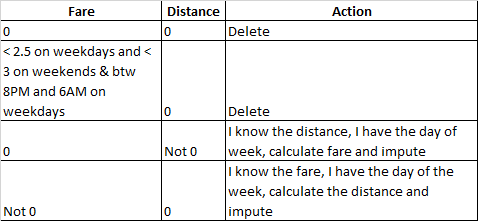


**SCENARIO 1**

Fare and Distance are both 0. According to the table above, we shall delete them as they do not provide us any info with regards to the data.

In [ ]:
train[(train['H_Distance']==0)&(train['fare_amount']==0)]

There are 4 rows. There 4 rows do not help us in anyway as we do not know either the distance or the fare to impute the missing values. So we shall drop them 

In [ ]:
train = train.drop(train[(train['H_Distance']==0)&(train['fare_amount']==0)].index, axis = 0)

In [ ]:
#4 rows dropped
train[(train['H_Distance']==0)].shape

**SCENARIO 2**

Fare is not 0 and is less than the base amount, but Distance is 0.

Delete these rows as the minimum is $2.50, and these fares are incorrect values.

In [ ]:
#Between 6AM and 8PM on Mon-Fri
rush_hour = train.loc[(((train['Hour']>=6)&(train['Hour']<=20)) & ((train['Day of Week']>=1) & (train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 2.5))]
rush_hour

In [ ]:
train=train.drop(rush_hour.index, axis=0)

In [ ]:
train.shape

In [ ]:
#Between 8PM and 6AM on Mon-Fri
non_rush_hour = train.loc[(((train['Hour']<6)|(train['Hour']>20)) & ((train['Day of Week']>=1)&(train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0))]
#print(Counter(non_work_hours['Hour']))
#print(Counter(non_work_hours['Day of Week']))
non_rush_hour
#keep these. Since the fare_amount is not <2.5 (which is the base fare), these values seem legit to me.

In [ ]:
#Saturday and Sunday all hours
weekends = train.loc[((train['Day of Week']==0) | (train['Day of Week']==6)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0)]
weekends
#Counter(weekends['Day of Week'])
#keep these too. Since the fare_amount is not <2.5, these values seem legit to me.

From scenario 2, I can understand that the distance is 0, but the fare is all the minimum fare of $2.5. This could be because the passenger booked the cab but ended up cancelling to pay the base fare (not sure how this works in NYC, but I'm assuming that's how it is)

**SCENARIO 3**

Fare is 0, but Distance is not 0. These values need to be imputed.

I can calculate the fare as I have the distance. I shall use the following formula
> *fare = 2.5 + 1.56(H_Distance)*

In [ ]:
train.loc[(train['H_Distance']!=0) & (train['fare_amount']==0)]

In [ ]:
scenario_3 = train.loc[(train['H_Distance']!=0) & (train['fare_amount']==0)]

In [ ]:
len(scenario_3)

In [ ]:
#We do not have any distance values that are outliers.
scenario_3.sort_values('H_Distance', ascending=False)

In [ ]:
scenario_3['fare_amount'] = scenario_3.apply(
    lambda row: ((row['H_Distance'] * 1.56) + 2.50), axis=1
)

In [ ]:
scenario_3['fare_amount']

In [ ]:
train.update(scenario_3)

In [ ]:
train.shape

**SCENARIO 4**

Fare is  not 0, but Distance is 0. These values need to be imputed.

In [ ]:
train.loc[(train['H_Distance']==0) & (train['fare_amount']!=0)]

In [ ]:
scenario_4 = train.loc[(train['H_Distance']==0) & (train['fare_amount']!=0)]

In [ ]:
len(scenario_4)

In [ ]:
#Using our prior knowledge about the base price during weekdays and weekends for the cabs.
#I do not want to impute these 1502 values as they are legible ones.
scenario_4.loc[(scenario_4['fare_amount']<=3.0)&(scenario_4['H_Distance']==0)]

In [ ]:
scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]

These 27159 rows need to be imputed using the following formula - 
> *distance = (fare_amount - 2.5)/1.56*

In [ ]:
scenario_4_sub = scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]

In [ ]:
len(scenario_4_sub)

In [ ]:
scenario_4_sub['H_Distance'] = scenario_4_sub.apply(
lambda row: ((row['fare_amount']-2.50)/1.56), axis=1
)

In [ ]:
train.update(scenario_4_sub)

In [ ]:
train.shape

**PART 2 --> MODELLING AND PREDICTION**

FINALLY! Data cleansing is done! Now to split the x and y variables and proceed to modelling. I shall use the random forest method for prediction

In [ ]:
train.columns

In [ ]:
test.columns

In [ ]:
#not including the pickup_datetime columns as datetime columns cannot be directly used while modelling. Features need to extracted from the 
#timestamp fields which will later be used as features for modelling.
train = train.drop(['key','pickup_datetime'], axis = 1)
test = test.drop(['key','pickup_datetime'], axis = 1)

In [ ]:
train.columns

In [ ]:
test.columns

In [ ]:
x_train = train.iloc[:,train.columns!='fare_amount']
y_train = train['fare_amount'].values
x_test = test

In [ ]:
x_train.shape

In [ ]:
x_train.columns

In [ ]:
y_train.shape

In [ ]:
x_test.shape

In [ ]:
x_test.columns

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
#print(rf_predict)

In [ ]:
submission = pd.read_csv('../input/new-york-city-taxi-fare-prediction/sample_submission.csv')
submission['fare_amount'] = rf_predict
submission.to_csv('submission_1.csv', index=False)
submission.head(20)

**BOOSTING USING LGBM**

This is my first attempt at using a boosting algorithm such as LGBM. Let's see if LGBM really lives up to its hype of improving scores. My intital score with just the RF was 3.39 and placed me in the top 20%.

In [ ]:
import lightgbm as lgbm

In [ ]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

In [ ]:
pred_test_y = np.zeros(x_test.shape[0])
pred_test_y.shape

In [ ]:
train_set = lgbm.Dataset(x_train, y_train, silent=True)
train_set

In [ ]:
model = lgbm.train(params, train_set = train_set, num_boost_round=300)

In [ ]:
print(model)

In [ ]:
pred_test_y = model.predict(x_test, num_iteration = model.best_iteration)

In [ ]:
print(pred_test_y)

In [ ]:
submission['fare_amount'] = pred_test_y
submission.to_csv('submission_LGB.csv', index=False)
submission.head(20)

**BOOSTING USING XGBM**

In [ ]:
import xgboost as xgb 

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

In [ ]:
dtrain

In [ ]:
#set parameters for xgboost
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 50

In [ ]:
xb = xgb.train(params, dtrain, num_rounds)

In [ ]:
y_pred_xgb = xb.predict(dtest)
print(y_pred_xgb)

In [ ]:
submission['fare_amount'] = y_pred_xgb
submission.to_csv('submission_XGB.csv', index=False)
submission.head(20)

And that's a wrap! With the Random Forest code I, got a score of 3.39, which was in the top 20%, with LGBM I got a score of 3.37 (which wasn't a great improvement from my initial RF model but helped me jump a couple of places up the leaderboard), and with XGBoost I got a 3.61, which is the worst of all my submissions. Maybe parameter tuning would help further. :) 